# Essentiality analysis

The goal of this analysis is to ensure the model correctly predicts the presence or absence of cell growth for well known mutants. Unlike for _E. coli_, extensive mutant libraries have not been charcterized for _C. therm._, in part due to the lack of well-stablish genetic engineering tools. Rather, a few mutants of biotechnological relevance have been relatively well studied.

## Background

### HydG-ech derived mutants

The standard for GEM model validation is the prediction of essentiality phenotypes. In particular, those relevant to metabolic engineering of _C. thermocellum_ should be predicted accurately to prevent designs which grow in-silico but are lethal in vivo.

In the publication 
> Thompson, R. Adam, et al. "Elucidating central metabolic redox obstacles hindering ethanol production in Clostridium thermocellum." Metabolic engineering 32 (2015): 207-219."

different lethal phenotypes captured by a core model are presented. The experimental evidence is provided in the figure below.

Fig. 5. Growth characteristics of parent strain (triangles) and ΔhydG Δech (circles) in MTC media (filled symbols) or MTC with the PFL inhibitor hypophosphite (open symbols). To investigate redox bottlenecks, no additional electron sink (A), 20 mM fumarate (B), 20 mM 2-ketoisovalerate (C), or 2 g/L total sulfate (D) were included in the medium to probe NADH, NAD(P)H, and Fdrd, respectively.

<img src="./fig5_thompson2015.jpg" alt="Drawing" style="width: 100px;"/>

Based on this evidence, the following phenotypes should be captured by the model:
1. hydG-ech-pfl deletion is lethal
2. hydG-ech-pfl deletion can recover growth in the presence of an external electron sink, either sulfate or kiv.
3. The failure of fumarate addition to recover growth indicates that fumarate reductase is not active in this mutant or fumarate uptake rate is not sufficient.

The most important being phenotype 1.

## LL1210 related mutants
The publication 
> Tian, Liang, et al. "Simultaneous achievement of high ethanol yield and titer in Clostridium thermocellum." Biotechnology for biofuels 9.1 (2016): 116.

studies the mutant with deletion of hydG, ldh, pfl, pta-ackA

| Strain name | Description                                                | Growth rate μ (h−1) |
|-------------|------------------------------------------------------------|---------------------|
| AG553       | C. thermocellum DSM1313 Δhpt ΔhydG Δldh Δpfl Δpta-ack [10] | 0.06 ± 0.01         |
| AG601       | Selected from AG553 after first stage adaptive evolution   | 0.10 ± 0.01         |
| LL1210      | Selected from AG601 after second stage adaptive evolution  | 0.22 ± 0.02         |

As a reference a wild type in avicell tubes grows at 0.33-0.39 (h-1) (see extracelular flux table). While it is not crucial to capture the quantitative change in growth rate it is imporant to ensure that:
3. hydg-ldh-pfl-pta/ack mutant can grow

# Model simulations

In [1]:
import os
import sys
sys.path.append('/home/sergio/Dropbox/s/cthermgem-dev/')

import numpy as np
import tools.conf_model
import cobra as cb
import settings
#from tools.essentiality import *
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
model = cb.io.load_json_model(os.path.join(settings.PROJECT_ROOT,'iCBI', 'iCBI655bigg_cellb_batch.json'))

#Several features were updated after this notebook, thus to make the code reproducible, this features must be reverted to their original state:
model.reactions.EX_h2s_e.bounds = (0,1000) # Enable sulfide secretion

## Phenotype 1: hydG-ech-pfl mutant cannot growth in minimal medium

In [2]:
r_wt = model.optimize()
print('Growth rate of wt: {:.2f}'.format(r_wt.objective_value))

mut_ko = ['BIF','H2ASE_syn', 'PFL', 'ECH']
with model as tmodel:
    [tmodel.reactions.get_by_id(rxn_id).knock_out() for rxn_id in mut_ko]
    r = tmodel.optimize()
    print('Growth rate of hydG-ech-pfl ko: {:.2f} \t fraction of wt: {:.2f}'.format(r.objective_value, r.objective_value/r_wt.objective_value))    
    tmodel.summary()

Growth rate of wt: 0.38
Growth rate of hydG-ech-pfl ko: 0.25 	 fraction of wt: 0.64
IN FLUXES         OUT FLUXES          OBJECTIVES
----------------  ------------------  ----------------------
cellb_e  4        h_e       16.8      BIOMASS_CELL...  0.246
nh4_e    1.67     lac__L_e  13.2
k_e      0.233    co2_e      0.735
pi_e     0.195    h2s_e      0.102
so4_e    0.133    h2o_e      0.0502
mg2_e    0.0336   gly_e      0.00983
fe3_e    0.00114  phe__L_e   0.00664
ca2_e    0.00106


The growth rate of this mutant is >50% that of the wild type. GEMs are known to overpredict growth since they do not account for important kinetic and regulatory limiations. However, lethality is often consired around a reduction of 80-90% of the theoretical maximum. Using that reference, we can say that __the model is failing to predict the lethality phenotype.__

We observe sulfide secretion, this pathway was studied by Thompson 2015 and further analyzed by [Biswas 2017]( https://biotechnologyforbiofuels.biomedcentral.com/articles/10.1186/s13068-016-0684-x). Biswas 2017 observed a range of 10-20 umol depending on the mutant. 
    

In [3]:
with model as tmodel:
    [tmodel.reactions.get_by_id(rxn_id).knock_out() for rxn_id in mut_ko]
    tmodel.reactions.EX_h2s_e.knock_out()
    rmut = tmodel.optimize()
    tmodel.summary()

with model as tmodel:
    tmodel.reactions.EX_h2s_e.knock_out()
    r = tmodel.optimize()
    print('WT-EX_h2s_e gr: {:.2f}'.format(r.objective_value))

print('Fraction of wt growth: {:.2f}'.format(rmut.objective_value/r.objective_value))

deleted_rxns = ['EX_h2s_e']

IN FLUXES          OUT FLUXES          OBJECTIVES
-----------------  ------------------  ----------------------
cellb_e  4         h_e       16.3      BIOMASS_CELL...  0.226
nh4_e    1.72      lac__L_e  12.7
k_e      0.215     co2_e      0.863
pi_e     0.18      h2o_e      0.658
mg2_e    0.0309    phe__L_e   0.193
so4_e    0.0292    etoh_e     0.187
fe3_e    0.00105   gly_e      0.00904
ca2_e    0.000974
WT-EX_h2s_e gr: 0.38
Fraction of wt growth: 0.59


The elimination of sulfide secretion continues to reduce growth rate of the mutant.

The current understanding of this mutant is that POR cannot produce suficcient acetyl-coa for growth due to the accumulation of reduced ferredoxin. This opens two hypothesis that still explain growth:
1. An alternative source of Acetyl-CoA is active.
2. An alternative ferredoxin (or indirectly nad(p)h) oxidation pathway is active.

In [4]:
# Sources of accoa
with model as tmodel:
    [tmodel.reactions.get_by_id(rxn_id).knock_out() for rxn_id in mut_ko]
    [tmodel.reactions.get_by_id(rxn_id).knock_out() for rxn_id in deleted_rxns]
    rsol = tmodel.optimize()
    
    tmodel.metabolites.accoa_c.summary()
    # write solution
    sol = rsol.to_frame()
    sol.drop(columns='reduced_costs', inplace=True)
    sol.to_csv('hydgechpfl_fluxes.csv')

PRODUCING REACTIONS -- Acetyl_CoA_c0 (accoa_c)
----------------------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
58%  13.3    POR       coa_c + 2.0 fdxox_c + h_c + pyr_c --> accoa_c +...
42%   9.64   ACS       ac_c + atp_c + coa_c --> accoa_c + amp_c + h_c ...

CONSUMING REACTIONS -- Acetyl_CoA_c0 (accoa_c)
----------------------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
55%  12.7    ACALD     accoa_c + h_c + nadh_c --> acald_c + coa_c + nad_c
42%   9.54   PTAr      accoa_c + pi_c <=> actp_c + coa_c
1%    0.283  ACCOAC    accoa_c + atp_c + co2_c + h2o_c --> adp_c + 2.0...
1%    0.163  CS        accoa_c + h2o_c + oaa_c --> cit_c + coa_c + h_c


In the model POR is capable of fully generating all neccessary Acetyl-CoA, so the first hypothesis regarding alternative acetyl-CoA sources can be discarded. From a thermodynamic standpoint, the POR reaciton is generally favorable for a broad range of metaboltie concentrations as shown in panel (D) form the figure below. 

[Thompson and Trinh 2017](https://onlinelibrary.wiley.com/doi/full/10.1002/bit.26374) performed the following thermodynamic analysis of redox reactions:
    
<img src="./fig3_thompson2017.jpg" alt="Drawing" style="width: 100px;"/>

__Caption__: Effects of reactant and product concentrations on Gibbs energy, calculated using the eQuilibrator tool. (A) Alcohol dehydrogenase, ADHE, assuming 1 mM ethanol. (B) Lactate dehydrogenase, LDH, assuming 1.7 mM pyruvate. (C) Pyruvate:formate lyase, PFL, assuming 1.7 mM pyruvate. (D) Pyruvate:ferredoxin oxidoreductase, PFOR, assuming 1.7 mM pyruvate, and 1 mM CO2. (E) Energy conserving hydrogenase, ECH. (F) Bifurcating hydrogenase, BIF, assuming NADH/NAD+ ratio of 0.4. (G) Reduced ferredoxin:NAD+ oxidoreductase, RNF. (H) NADH‐dependent ferredoxin:NADP+ oxidoreductase, NFN, assuming NADPH/NADP+ ratio of 2. 
                    

We continue to investigate the second hypothesis regarding sources of ferredoxin turnover which should not be viable. 

In [5]:
with model as tmodel:
    [tmodel.reactions.get_by_id(rxn_id).knock_out() for rxn_id in mut_ko]
    [tmodel.reactions.get_by_id(rxn_id).knock_out() for rxn_id in deleted_rxns]
    tmodel.metabolites.fdxox_c.summary()
    tmodel.metabolites.nadh_c.summary()
    tmodel.metabolites.nadph_c.summary()

PRODUCING REACTIONS -- Oxidizedferredoxin_c0 (fdxox_c)
------------------------------------------------------
%       FLUX  RXN ID    REACTION
----  ------  --------  --------------------------------------------------
100%   27.4   RNF       2.0 fdxrd_c + nad_c <=> 2.0 fdxox_c + h_c + nadh_c

CONSUMING REACTIONS -- Oxidizedferredoxin_c0 (fdxox_c)
------------------------------------------------------
%       FLUX  RXN ID    REACTION
----  ------  --------  --------------------------------------------------
97%    26.6   POR       coa_c + 2.0 fdxox_c + h_c + pyr_c --> accoa_c +...
3%      0.83  FRNDPR2r  2.0 fdxrd_c + nadh_c + 2.0 nadp_c <=> 2.0 fdxox...
PRODUCING REACTIONS -- NADH_c0 (nadh_c)
---------------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
51%  15.1    GAPD      g3p_c + nad_c + pi_c <=> 13dpg_c + h_c + nadh_c
47%  13.7    RNF       2.0 fdxrd_c + nad_c <=> 2.0 fdxox_c + h_c + nadh_c
1%    0

As we can see RNF transforms all ferredoxin to NADH. All NADH is consumed between ethanol and MDH. Now the deletion of MDH (not shown above) activates alternative pathwyas which still enable growth. So at this point the complexity is to high for manual exploration and we need to systematically evaluate what deletions disable growth in the mutant but not in the wild type:

In [6]:
# wild type growth
with model as tmodel:
    tmodel.reactions.EX_h2s_e.knock_out()
    r = tmodel.optimize()
    wt_gr =r.objective_value

min_wt_gr  = 0.95*wt_gr
max_mut_gr = 0.20*wt_gr

In [7]:
# Single deletion
#WT
with model as tmodel:
    [tmodel.reactions.get_by_id(rxn_id).knock_out() for rxn_id in deleted_rxns]
    sd = cb.flux_analysis.single_reaction_deletion(tmodel)
    no_effect_wt = set(map(lambda x: list(x)[0],sd.index[sd['growth'] >= min_wt_gr]))
#Mut
with model as tmodel:
    [tmodel.reactions.get_by_id(rxn_id).knock_out() for rxn_id in mut_ko]
    [tmodel.reactions.get_by_id(rxn_id).knock_out() for rxn_id in deleted_rxns]
    sd = cb.flux_analysis.single_reaction_deletion(tmodel)
    lethal_mut = set(map(lambda x: list(x)[0],sd.index[sd['growth'] <= max_mut_gr]))
    
candidates = no_effect_wt.intersection(lethal_mut)

# display candidates:
for rid in candidates:
    print('{} \t {}'.format(rid, model.reactions.get_by_id(rid).reaction))

DRPA 	 2dr5p_c --> acald_c + g3p_c
MTHFC 	 h2o_c + methf_c <=> 10fthf_c + h_c
GLYt2r 	 gly_e + h_e <=> gly_c + h_c
PPM2 	 2dr1p_c <=> 2dr5p_c
EX_gly_e 	 gly_e --> 


Three solutions seem available, but only one is feasible:
1. Remove recyling of DNA/RNA sugars leading to acetaldehyde, which likely acts as electron sink. This pathway is not a well documented pathway in C. therm, and it is the only deletion which is consistent with growth recovery by addition of external electron sinks as shown below. 
2. Remove glycine secretion. This solutions is not consistent with growth recovery by addition of external electron sinks.
3. Remove MTHFC. This prevents the synthesis of essential biomass precursors. However, the experimental dataset demonstrates that by adding reducible compounds to the media growth can be recovered. Also note that MTHFC deletion makes PFL essential on its own, and this deletion is known to not be essential. 

In [8]:
with model as tmodel:
    [tmodel.reactions.get_by_id(rxn_id).knock_out() for rxn_id in mut_ko]
    tmodel.reactions.EX_h2s_e.knock_out()
    tmodel.reactions.DRPA.knock_out()

    rmut = tmodel.optimize()
    tmodel.summary()

with model as tmodel:
    tmodel.reactions.EX_h2s_e.knock_out()
    tmodel.reactions.DRPA.knock_out()
    r = tmodel.optimize()
    print('WT-EX_h2s_e gr: {:.2f}'.format(r.objective_value))

print('Fraction of wt growth: {:.2f}'.format(rmut.objective_value/r.objective_value))

deleted_rxns = ['EX_h2s_e', 'DRPA']

IN FLUXES       OUT FLUXES       OBJECTIVES
--------------  ---------------  -------------------------
cellb_e  0.357  co2_e     1.25   BIOMASS_CELL...  -3.5e-15
nh4_e    0.179  etoh_e    1.07
                val__L_e  0.179
                h_e       0.179
WT-EX_h2s_e gr: 0.38
Fraction of wt growth: -0.00


## Conclusion for Phenotype 1
1. A secondary pathway formed by DRPA which produced acetaldehyde and g3p from dUTP was disabled to avoid an uncharacterized electron skink. 
2. Sulfide secretion provided an electron sink. When high amounts of sulfate are provided to the medium, growth is observed. Otherwise we consider this pathway to not be relevant, and thus remove sulfide secretion.

Modification of these two features has no impact on wild type growth prediction but reduces mutant growth rate below 20% of the wild type maximum, which is considered lethal. 

# Phenotype 2: Do fumarate, sulfate, or ketoisovalerate recover growth in the mutant?

In the Core model publication cited at the begining, the addition of the following reactions in separate instances led the model to precit growth:

| ID    | Formula                                               | Genes             |
|-------|-------------------------------------------------------|-------------------|
| FUM1  | FUM_ext = FUM .                                       |                   |
| FUM2  | FUM + NADH = SUCC + NAD .                             | Clo1313_2640;3018 |
| FUM3  | SUCC = SUCC_ext.                                      |                   |
| ISOV1 | AKIV_ext = AKIV .                                     |                   |
| ISOV2 | AKIV + fdox + 2 NADPH = IBOH + CO2 + fdred + 2 NADP . | Clo1313_0382-383  |
| ISOV3 | IBOH = IBOH_ext .                                     |                   |
| SULF1 | SO4_ext = SO4 .                                       |                   |
| SULF2 | SO4 + fdred = SO3 + fdox .                            | Clo1313_0118-124  |
| SULF3 | SO3 + fdred = Sulfide + fdox .                        | Clo1313_0118-124  |
| SULF4 | Sulfide = Sulf_ext .                                  |                   |

As previously noted, only sulfate and kivd addition recover growth (albeit not as in the wild type, but rather with low growth or long lag phase)


## Fumarate


In [9]:
with model as tmodel:
    [tmodel.reactions.get_by_id(rxn_id).knock_out() for rxn_id in deleted_rxns]
    [tmodel.reactions.get_by_id(rxn_id).knock_out() for rxn_id in mut_ko]

    # allow fumarate input
    tmodel.reactions.EX_fum_e.bounds = (-1000,0)
    # fumraate reductase was added to the GEM. 
    # Include reaction converting fumarate to succinate, which is not present in the GEM
    #FUM2 = cb.Reaction(id='FUM2')
    #tmodel.add_reaction(FUM2)
    #tmodel.reactions.FUM2.reaction = 'fum_c + nadh_c + h_c => succ_c + nad_c'
    # allow succinate secretion
    tmodel.reactions.EX_succ_e.bounds = (0,1000)
    # tmodel.objective = 'FUM2' # check the reaction is not blocked
    r = tmodel.optimize()
    tmodel.summary()
    mut_fum_gr = r.objective_value

IN FLUXES          OUT FLUXES         OBJECTIVES
-----------------  -----------------  ---------------------
fum_e      1e+03   co2_e     684      BIOMASS_CELL...  3.88
h2o_e    618       succ_e    650
h_e      320       ac_e      322
nh4_e     26.4     gly_e       0.156
cellb_e    4       phe__L_e    0.105
k_e        3.69
pi_e       3.09
mg2_e      0.532
so4_e      0.501
fe3_e      0.018
ca2_e      0.0168


Fumarate predicts growth recovery consistently with the redox-imbalance hypothesis

## Sulfate
Sulfate is essential for the model, since it is used to provide sulfur for cysteine biosynthesis, as demonstrated by the plot below. 
However, we can simulate high concentrations of sulfate by enabling h2s secretion.

(0, 1000)


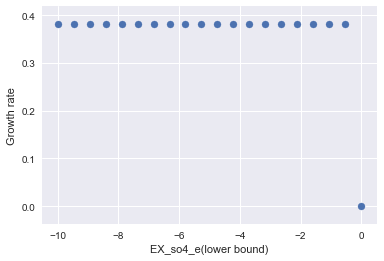

In [10]:
x = np.linspace(-10,0,20)
y = []
with model:
    for l in np.nditer(x):
        model.reactions.EX_so4_e.lower_bound = l
        y.append(model.optimize().objective_value)
plt.scatter(x,y)
plt.xlabel('EX_so4_e(lower bound)')
plt.ylabel('Growth rate')
print(model.reactions.EX_h2s_e.bounds)

In [11]:
with model as tmodel:
    [tmodel.reactions.get_by_id(rxn_id).knock_out() for rxn_id in deleted_rxns]
    [tmodel.reactions.get_by_id(rxn_id).knock_out() for rxn_id in mut_ko]

    # allow sulfide secretion
    tmodel.reactions.EX_h2s_e.bounds = (0,1000)

    # tmodel.objective = 'FUM2' # check the reaction is not blocked
    mut_sul_gr = tmodel.optimize().objective_value
    tmodel.summary()

IN FLUXES         OUT FLUXES          OBJECTIVES
----------------  ------------------  ----------------------
cellb_e  4        h_e       16.8      BIOMASS_CELL...  0.246
nh4_e    1.67     lac__L_e  13.2
k_e      0.233    co2_e      0.735
pi_e     0.195    h2s_e      0.102
so4_e    0.133    h2o_e      0.0502
mg2_e    0.0336   gly_e      0.00983
fe3_e    0.00114  phe__L_e   0.00664
ca2_e    0.00106


Indeed so4 uptake is significantly increased, and a significant efflux of h2s enables growth.

## KIV

Here we enable the isobutanol pathway providing one of its intermediates

In [12]:
with model as tmodel:
    [tmodel.reactions.get_by_id(rxn_id).knock_out() for rxn_id in deleted_rxns]
    [tmodel.reactions.get_by_id(rxn_id).knock_out() for rxn_id in mut_ko]
    tmodel.reactions.EX_ibutoh_e.bounds = (0,1000)
    sk = tmodel.add_boundary(tmodel.metabolites.get_by_id('3mob_c'))
    mut_kiv_gr = tmodel.optimize().objective_value
    tmodel.summary()

IN FLUXES          OUT FLUXES         OBJECTIVES
-----------------  -----------------  ----------------------
h2o_e    10.7      co2_e     38.1     BIOMASS_CELL...  0.386
h_e       7.31     ibutoh_e  24.9
cellb_e   4        ac_e      11.9
nh4_e     2.63     gly_e      0.0155
k_e       0.367    phe__L_e   0.0104
pi_e      0.307
mg2_e     0.0529
so4_e     0.0498
fe3_e     0.00179
ca2_e     0.00167


Again this fully recovers growth. Unlike fumarate, growth rate goes back to the wild-type level. 

## Conclusion for phenotype 2:
The predictions are consistent with the core model, which accuratly represented experimental observations with the exception of fumarate. 

## Phenotype 3: Growth of LL1210

As shown below the strain is able to grow, consistently with experimental observations.

In [13]:
# ll1210 mutant
with model as tmodel:
    [tmodel.reactions.get_by_id(rxn_id).knock_out() for rxn_id in deleted_rxns]
    r_wt = model.optimize()
    wt_gr = r_wt.objective_value
    tmodel.reactions.BIF.knock_out() #hydg
    tmodel.reactions.H2ASE_syn.knock_out() #hydg
    tmodel.reactions.PFL.knock_out()
    tmodel.reactions.LDH_L.knock_out()
    tmodel.reactions.PTAr.knock_out()
    tmodel.reactions.ACKr.knock_out()
    
    r = tmodel.optimize()
    ll1210_gr = r.objective_value
    tmodel.summary()
    print('Growth rate of wt: {:.2f}, growth rate of Mut: {:.2f}, fraction: {:.2f}'.format(
        r_wt.objective_value, r.objective_value, r.objective_value/r_wt.objective_value))

    

IN FLUXES          OUT FLUXES         OBJECTIVES
-----------------  -----------------  ----------------------
h2o_e    10.2      h2_e      24.3     BIOMASS_CELL...  0.381
cellb_e   4        h_e       17.3
nh4_e     2.6      co2_e     13
k_e       0.363    ac_e      11.5
pi_e      0.303    gly_e      0.0153
mg2_e     0.0522   phe__L_e   0.0103
so4_e     0.0493
fe3_e     0.00177
ca2_e     0.00165
Growth rate of wt: 0.38, growth rate of Mut: 0.38, fraction: 1.00


## Conclusion for phenotype 3
As expected, the LL1210 mutant is able to to grow. 